cpu


Epoch Loss:386.775: 100%|██████████| 800/800 [07:47<00:00,  1.71it/s]  


fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


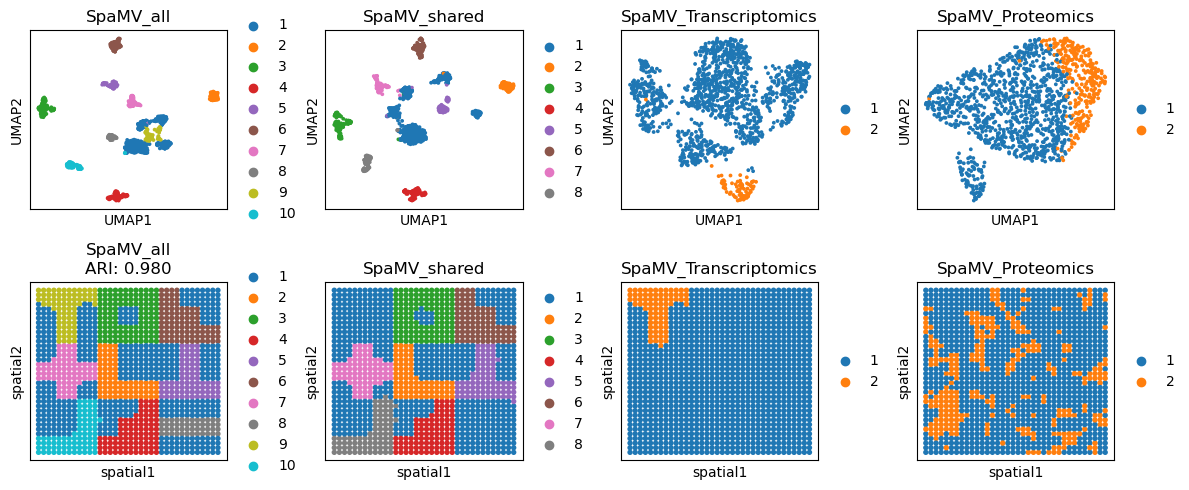

cpu


Epoch Loss:392.954: 100%|██████████| 800/800 [06:19<00:00,  2.11it/s]


fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


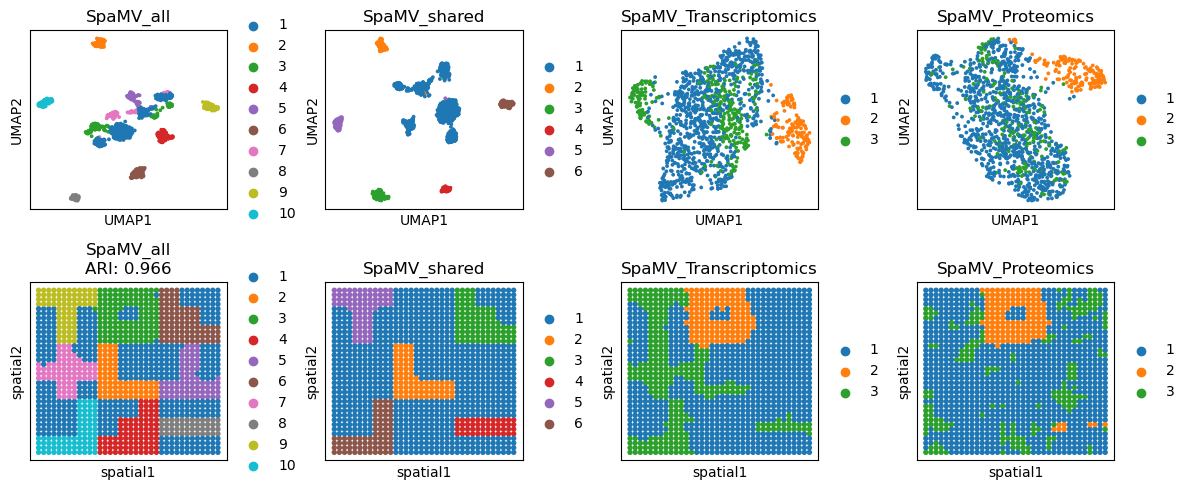

cpu


Epoch Loss:389.836: 100%|██████████| 800/800 [05:55<00:00,  2.25it/s]


fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


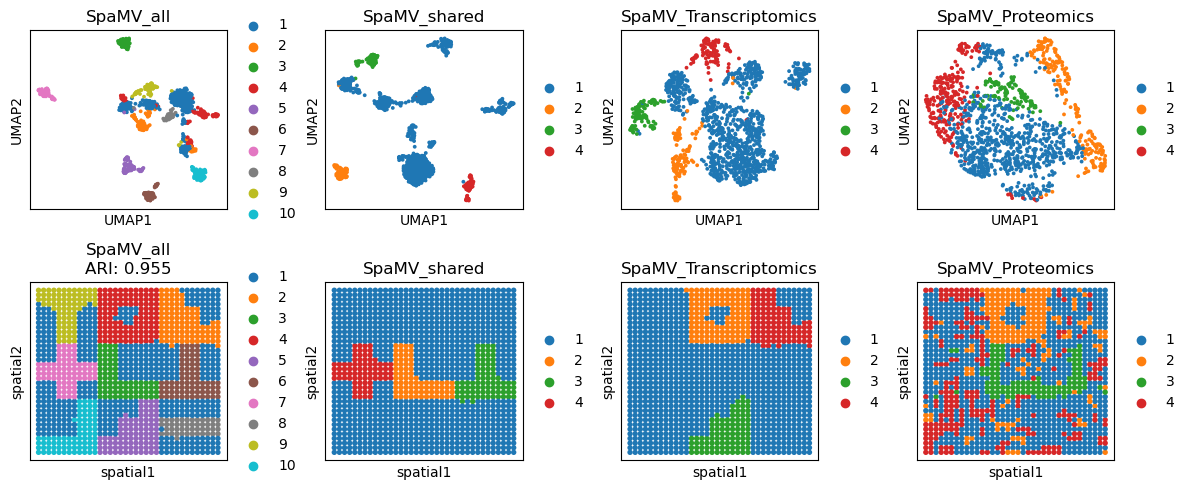

In [19]:
import os
import anndata
import torch
from sklearn.metrics import adjusted_rand_score
import torch.nn.functional as F
from Methods.SpaMV.spamv import SpaMV
from Methods.SpaMV.utils import pca, clr_normalize_each_cell, clustering
import scanpy as sc
import matplotlib.pyplot as plt
import wandb

os.environ["WANDB_SILENT"] = "true"
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.WARN)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
for dataset in ['1_Simulation', '2_Simulation', '3_Simulation']:
    data_rna = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
    data_pro = sc.read_h5ad('../Dataset/' + dataset + '/adata_ADT.h5ad')

    sc.pp.normalize_total(data_rna, target_sum=1e4)
    sc.pp.log1p(data_rna)
    sc.pp.scale(data_rna)
    adata_rna = anndata.AnnData(pca(data_rna, n_comps=50), obs=data_rna.obs, obsm=data_rna.obsm)
    data_pro = clr_normalize_each_cell(data_pro)
    sc.pp.scale(data_pro)
    adata_pro = anndata.AnnData(pca(data_pro, n_comps=50), obs=data_pro.obs, obsm=data_pro.obsm)

    wandb.init()
    wandb.login()
    model = SpaMV([adata_rna, adata_pro], interpretable=False, beta=[10, 10], neighborhood_embedding=0,
                  recon_types=['gauss', 'gauss'], omics_names=['Transcriptomics', 'Proteomics'])
    model.train()
    wandb.finish()

    output = model.get_embedding()
    for emb_type in ['all', 'shared', 'Transcriptomics', 'Proteomics']:
        name = 'SpaMV_' + emb_type
        if emb_type == 'all':
            adata_rna.obsm[name] = F.normalize(output, p=2, eps=1e-12, dim=1).detach().cpu().numpy()
            n_clusters = 10
        elif emb_type == 'shared':
            adata_rna.obsm[name] = F.normalize(output[:, :32], p=2, eps=1e-12, dim=1).detach().cpu().numpy()
            if dataset == '1_Simulation':
                n_clusters = 8
            elif dataset == '2_Simulation':
                n_clusters = 6
            elif dataset == '3_Simulation':
                n_clusters = 4
            else:
                raise ValueError('Unknown dataset: {}'.format(dataset))
        else:
            if dataset == '1_Simulation':
                n_clusters = 2
            elif dataset == '2_Simulation':
                n_clusters = 3
            elif dataset == '3_Simulation':
                n_clusters = 4
            else:
                raise ValueError('Unknown dataset: {}'.format(dataset))
            adata_rna.obsm[name] = F.normalize(output[:, 32:64] if emb_type == 'Transcriptomics' else output[:, 64:],
                                               p=2, eps=1e-12, dim=1).detach().cpu().numpy()
        clustering(adata_rna, key=name, add_key=name, n_clusters=n_clusters, method='mclust', use_pca=True)
        sc.pp.neighbors(adata_rna, use_rep=name, n_neighbors=30, key_added=name)
    fig, ax_list = plt.subplots(2, 4, figsize=(12, 5))
    i = 0
    for emb_type in ['all', 'shared', 'Transcriptomics', 'Proteomics']:
        name = 'SpaMV_' + emb_type
        sc.tl.umap(adata_rna, neighbors_key=name)
        sc.pl.umap(adata_rna, color=name, ax=ax_list[0][i], s=30, show=False)
        sc.pl.embedding(adata_rna, color=name, basis='spatial', ax=ax_list[1][i], s=60, show=False,
                        title=name + '\nARI: {:.3f}'.format(adjusted_rand_score(adata_rna.obs['cluster'], adata_rna.obs[
                            name])) if emb_type == 'all' else name)
        i += 1
    plt.tight_layout(w_pad=0.3)
    # plt.savefig('Spamv_' + dataset + '_' + emb_type + '.pdf')
    plt.show()
    a = 1
